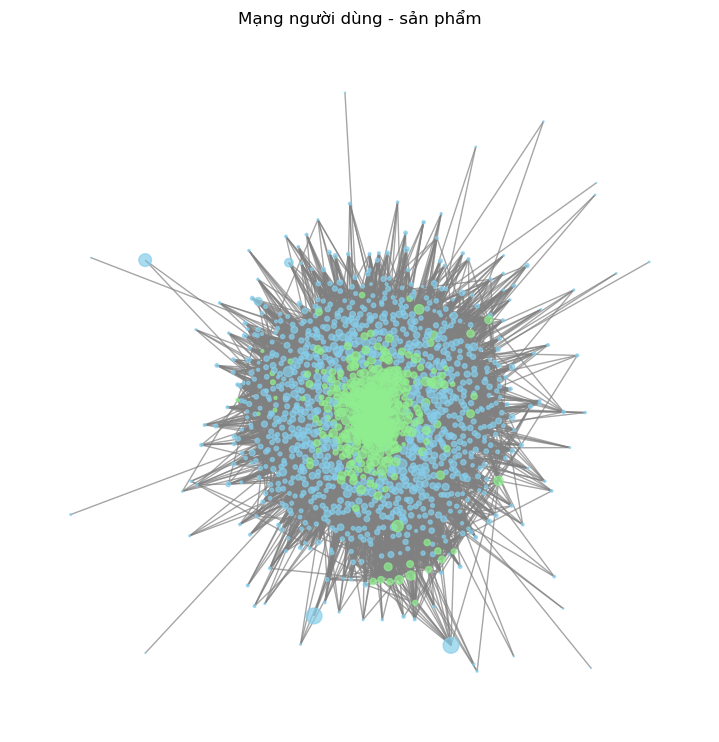

In [ ]:
# ========== PHẦN 1: VẼ MẠNG NGƯỜI DÙNG - SẢN PHẨM ==========
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

file_path = "./transactions_top1000cust_top500articles.csv"
df = pd.read_csv(file_path)
df = df[(df['customer_id'].notna()) & df['prod_name'].notna()]

# Giữ lại top 50 người dùng và 50 sản phẩm
#top_users = df['customer_id'].value_counts().nlargest(500).index
#top_items = df['prod_name'].value_counts().nlargest(500).index
#df_filtered = df[df['customer_id'].isin(top_users) & df['prod_name'].isin(top_items)]
df_filtered = df
# Tạo đồ thị bằng NetworkX
G = nx.Graph()
for row in df_filtered.itertuples():
    user = f"user_{row.customer_id}"
    item = f"item_{row.prod_name}"
    G.add_node(user, type='user')
    G.add_node(item, type='item')
    G.add_edge(user, item)

# Tính độ lớn nút
user_counts = df_filtered.groupby("customer_id")["total"].sum().to_dict()
item_counts = df_filtered.groupby("prod_name")["total"].sum().to_dict()
node_sizes = []
node_colors = []
for node in G.nodes():
    if node.startswith("user_"):
        uid = node.replace("user_", "")
        size = user_counts.get(uid, 1)
        node_sizes.append(size * 10)
        node_colors.append("skyblue")
    else:
        iid = node.replace("item_", "")
        size = item_counts.get(iid, 1)
        node_sizes.append(size * 10)
        node_colors.append("lightgreen")

# Vẽ mạng
plt.figure(figsize=(7, 7))
pos = nx.spring_layout(G, k=0.2)
nx.draw(G, pos, node_size=node_sizes, node_color=node_colors, edge_color='gray', alpha=0.7, with_labels=False)
plt.title("Mạng người dùng - sản phẩm")
plt.savefig("mang.jpg", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
#cài các thư viện để chạy GNN chỉ cần chạy lần đầu tiên thôi
!pip install torch torchvision torchaudio
import torch
print(torch.__version__)
print("✅ PyTorch đã được cài thành công!")
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric
import torch_geometric
print("✅ torch_geometric đã được cài thành công!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.5 MB/s eta 0:00:00
2.6.0
✅ PyTorch đã được cài thành công!
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [53 lines of output]
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      running bdist_wheel
      running build
      running build_py
      creating build/lib.macosx-11.1-arm64-cpython-312/torch_scatter
      copying torch_scatter/placeholder.py -> build/lib.macosx-11.1-arm64-cpython-312/torch_scatter
      copying torch_scatter/__init__.py -> build/lib.m

In [ ]:
# ========== PHẦN 2: GNN DỰ ĐOÁN MẶT HÀNG ==========
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Tạo ánh xạ ID -> số nguyên liên tục
user_ids = df_filtered['customer_id'].unique()
item_ids = df_filtered['prod_name'].unique()
user_map = {uid: i for i, uid in enumerate(user_ids)}
item_map = {iid: i+len(user_ids) for i, iid in enumerate(item_ids)}

# Tạo danh sách cạnh
edges = []
for row in df_filtered.itertuples():
    u = user_map[row.customer_id]
    i = item_map[row.prod_name]
    edges.append([u, i])
    edges.append([i, u])

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# One-hot vector cho mỗi node
num_nodes = len(user_map) + len(item_map)
x = torch.eye(num_nodes, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)

# GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GCN(in_channels=num_nodes, hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Negative sampling đơn giản
def negative_sampling(edge_index, num_nodes, num_samples):
    neg_edges = set()
    edges = set(tuple(e) for e in edge_index.t().tolist())
    while len(neg_edges) < num_samples:
        i = torch.randint(0, num_nodes, (1,)).item()
        j = torch.randint(0, num_nodes, (1,)).item()
        if i != j and (i, j) not in edges and (j, i) not in edges:
            neg_edges.add((i, j))
    return torch.tensor(list(neg_edges), dtype=torch.long).t()

# Tạo tập huấn luyện
num_pos = edge_index.size(1)
neg_edge_index = negative_sampling(edge_index, num_nodes, num_pos)

def get_link_labels(pos_edge_index, neg_edge_index):
    return torch.cat([
        torch.ones(pos_edge_index.size(1)),
        torch.zeros(neg_edge_index.size(1))
    ])

def compute_loss(z, pos_edge_index, neg_edge_index):
    total_edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
    z_i = z[total_edge_index[0]]
    z_j = z[total_edge_index[1]]
    pred = (z_i * z_j).sum(dim=1)
    labels = get_link_labels(pos_edge_index, neg_edge_index)
    return F.binary_cross_entropy_with_logits(pred, labels)

# Train model
model.train()
for epoch in range(1, 51):
    optimizer.zero_grad()
    z = model(data.x, edge_index)
    loss = compute_loss(z, edge_index, neg_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Dự đoán sản phẩm tiếp theo cho một người dùng cụ thể
model.eval()
with torch.no_grad():
    z = model(data.x, edge_index)
    test_user = list(user_map.keys())[0]
    user_idx = user_map[test_user]
    print(f"\nDự đoán mặt hàng tiếp theo cho người dùng: {test_user}\n")
    scores = []
    for item, item_idx in item_map.items():
        score = (z[user_idx] * z[item_idx]).sum().item()
        scores.append((item, score))

    top_items = sorted(scores, key=lambda x: x[1], reverse=True)[:10]
    for item, score in top_items:
        print(f"{item} | score: {score:.4f}")


Epoch 10, Loss: 0.6667
Epoch 20, Loss: 0.6519
Epoch 30, Loss: 0.6377
Epoch 40, Loss: 0.6307
Epoch 50, Loss: 0.6290

Dự đoán mặt hàng tiếp theo cho người dùng: 08ddd7be3e60252d2cba9dd55297a6ad0bdc1f4e244a16a8ebf61b73c56557c5

Jade HW Skinny Denim TRS | score: 4.2810
Luna skinny RW | score: 3.4500
Perrie Slim Mom Denim TRS | score: 2.6999
Tilly (1) | score: 2.5410
Therese tee | score: 2.4773
Julia RW Skinny Denim TRS | score: 2.4195
Shaping Skinny H.W | score: 2.3919
Push Up Jegging L.W | score: 2.3809
Madison skinny HW (1) | score: 2.2359
Timeless Midrise Brief | score: 2.2032


In [ ]:
# ===== TÍNH CÁC CHỈ SỐ CENTRALITY =====
deg_centrality = nx.degree_centrality(G)
btw_centrality = nx.betweenness_centrality(G)
eig_centrality = nx.eigenvector_centrality(G, max_iter=500)

# Gom lại thành DataFrame
centrality_df = pd.DataFrame({
    'node': list(G.nodes()),
    'degree': [deg_centrality[n] for n in G.nodes()],
    'betweenness': [btw_centrality[n] for n in G.nodes()],
    'eigenvector': [eig_centrality[n] for n in G.nodes()],
    'type': ['user' if n.startswith('user_') else 'item' for n in G.nodes()]
})

# ===== TOP 10 THEO TỪNG CHỈ SỐ - TOÀN MẠNG =====
print("🔹 Top 10 node theo Degree Centrality:")
print(centrality_df.sort_values(by='degree', ascending=False).head(10)[['node', 'type', 'degree']])

print("\n🔹 Top 10 node theo Betweenness Centrality:")
print(centrality_df.sort_values(by='betweenness', ascending=False).head(10)[['node', 'type', 'betweenness']])

print("\n🔹 Top 10 node theo Eigenvector Centrality:")
print(centrality_df.sort_values(by='eigenvector', ascending=False).head(10)[['node', 'type', 'eigenvector']])

# ===== TOP 10 KHÁCH HÀNG THEO TỪNG CHỈ SỐ =====
user_df = centrality_df[centrality_df['type'] == 'user']

print("\n👤 Top 10 KHÁCH HÀNG theo Degree Centrality:")
print(user_df.sort_values(by='degree', ascending=False).head(10)[['node', 'degree']])

print("\n👤 Top 10 KHÁCH HÀNG theo Betweenness Centrality:")
print(user_df.sort_values(by='betweenness', ascending=False).head(10)[['node', 'betweenness']])

print("\n👤 Top 10 KHÁCH HÀNG theo Eigenvector Centrality:")
print(user_df.sort_values(by='eigenvector', ascending=False).head(10)[['node', 'eigenvector']])


🔹 Top 10 node theo Degree Centrality:
                                   node  type    degree
5                   item_Luna skinny RW  item  0.214545
817       item_Jade HW Skinny Denim TRS  item  0.190545
297      item_Perrie Slim Mom Denim TRS  item  0.138182
41                       item_Tilly (1)  item  0.133818
1240                   item_Therese tee  item  0.130909
1092                   item_Lucy blouse  item  0.127273
17              item_Shaping Skinny H.W  item  0.121455
1263  item_Vintage Slim HW ankle consc.  item  0.120727
1017        item_Timeless Midrise Brief  item  0.120000
1109              item_Mom Fit Ultra HW  item  0.113455

🔹 Top 10 node theo Betweenness Centrality:
                                   node  type  betweenness
5                   item_Luna skinny RW  item     0.045153
817       item_Jade HW Skinny Denim TRS  item     0.031287
297      item_Perrie Slim Mom Denim TRS  item     0.018176
41                       item_Tilly (1)  item     0.017162
1240   

In [ ]:
!pip install python-louvain

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9402 sha256=a0e482aef215ec3e2aeb42fa73352435ecb1746cd3ec7d2b0cb79b0097b34392
  Stored in directory: c:\users\nguye\appdata\local\pip\cache\wheels\40\f1\e3\485b698c520fa0baee1d07897abc7b8d6479b7d199ce96f4af
Successfully built python-louvain


In [ ]:
import community.community_louvain as community_louvain

# Chạy thuật toán Louvain để phân cụm
partition = community_louvain.best_partition(G)

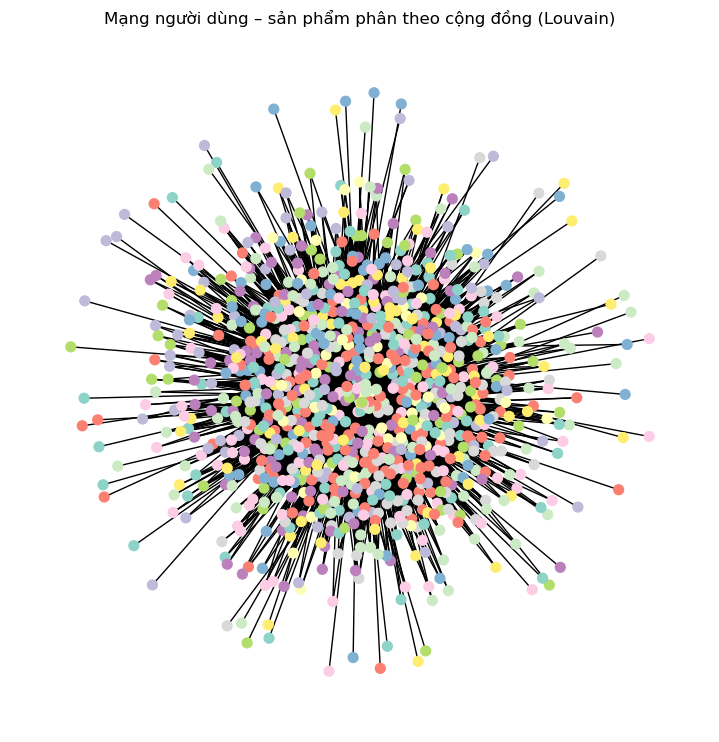

In [ ]:
# ========== PHẦN 1: CLUSTERING (Louvain) CỘNG ĐỒNG ==========

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import community.community_louvain as community_louvain

# Đọc dữ liệu và xử lý
#file_path = "./transactions_top1000cust_top500articles.csv"
#df = pd.read_csv(file_path)
#df = df[(df['customer_id'].notna()) & df['prod_name'].notna()]
top_users = df['customer_id'].value_counts().nlargest(1000).index
top_items = df['prod_name'].value_counts().nlargest(50).index
df_filtered = df[df['customer_id'].isin(top_users) & df['prod_name'].isin(top_items)]

# Tạo đồ thị hai lớp
G = nx.Graph()
for row in df_filtered.itertuples():
    user = f"user_{row.customer_id}"
    item = f"item_{row.prod_name}"
    G.add_node(user, type='user')
    G.add_node(item, type='item')
    G.add_edge(user, item)

# Ánh xạ cộng đồng bằng Louvain
partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, name='community')

# Trực quan hóa mạng theo cộng đồng
colors = [partition[n] for n in G.nodes()]
pos = nx.spring_layout(G, k=0.2)
plt.figure(figsize=(7, 7))
nx.draw(G, pos, node_color=colors, with_labels=False, node_size=50, cmap=plt.cm.Set3)
plt.title("Mạng người dùng – sản phẩm phân theo cộng đồng (Louvain)")
plt.savefig("clusters_Louvain.jpg", dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# ========== PHẦN 2: PAGERANK TRONG TỪNG CỘNG ĐỒNG ==========
# Tính PageRank toàn mạng
from collections import defaultdict
pagerank = nx.pagerank(G)

# Gom các sản phẩm theo cộng đồng
community_items = defaultdict(list)
for node, group in partition.items():
    if node.startswith("item_"):
        community_items[group].append(node)

# In top sản phẩm có PageRank cao nhất theo từng cộng đồng
for com, items in community_items.items():
    top_items = sorted(items, key=lambda x: pagerank[x], reverse=True)[:5]
    print(f"\n🎯 Cộng đồng {com} – sản phẩm hot theo PageRank:")
    for item in top_items:
        print(f" - {item.replace('item_', '')} | PageRank: {pagerank[item]:.4f}")


🎯 Cộng đồng 6 – sản phẩm hot theo PageRank:
 - Lucy blouse | PageRank: 0.0034
 - Chestnut strap top | PageRank: 0.0027
 - Shaping Skinny R.W. | PageRank: 0.0021
 - Jennifer Top | PageRank: 0.0020
 - Capri blazer | PageRank: 0.0017

🎯 Cộng đồng 2 – sản phẩm hot theo PageRank:
 - Jade HW Skinny Denim TRS | PageRank: 0.0050
 - Tilly (1) | PageRank: 0.0035
 - Jennifer | PageRank: 0.0030
 - Madison skinny HW (1) | PageRank: 0.0029
 - Julia RW Skinny Denim TRS | PageRank: 0.0026

🎯 Cộng đồng 0 – sản phẩm hot theo PageRank:
 - Luna skinny RW | PageRank: 0.0057
 - Milk RW slacks | PageRank: 0.0029
 - Bow HW paperwaist | PageRank: 0.0017
 - Fake 1p Leggings | PageRank: 0.0015
 - Noa skinny trouser | PageRank: 0.0012

🎯 Cộng đồng 5 – sản phẩm hot theo PageRank:
 - Therese tee | PageRank: 0.0035
 - Midnight | PageRank: 0.0028
 - Timeless Sports Top | PageRank: 0.0028
 - The Low Line Highwaist | PageRank: 0.0028
 - Peggy Trouser | PageRank: 0.0022

🎯 Cộng đồng 7 – sản phẩm hot theo PageRank:
 - S

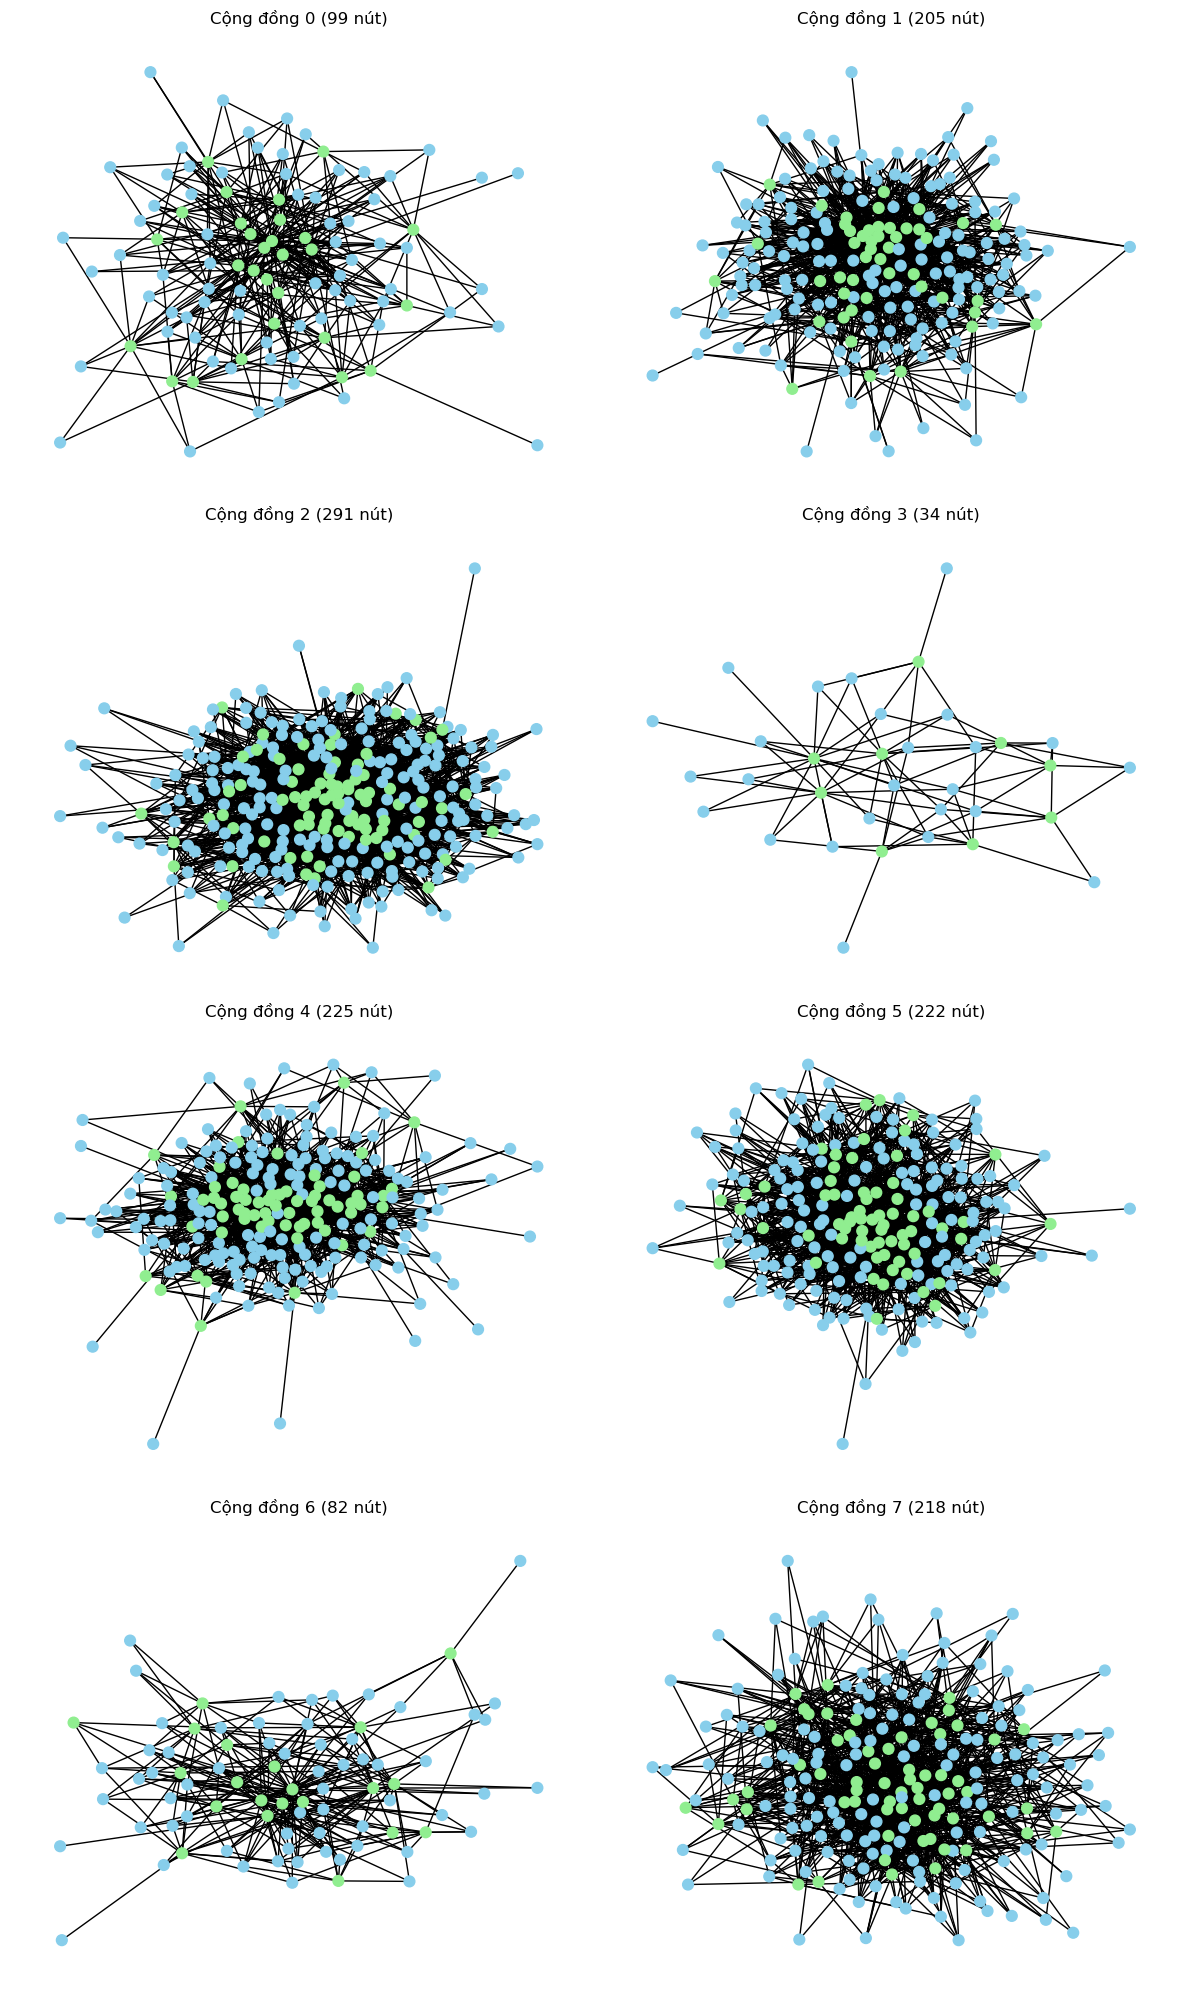

In [ ]:
# ========== PHẦN 3: VẼ TỪNG CỘNG ĐỒNG RIÊNG BIỆT ==========
import math

# Xác định số lượng cộng đồng
unique_communities = sorted(set(partition.values()))
num_coms = len(unique_communities)

# Tạo figure chia nhỏ theo subplot
cols = 2  # số cột hình
rows = math.ceil(num_coms / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))

# Đảm bảo axes là dạng mảng phẳng
axes = axes.flatten()

for i, com in enumerate(unique_communities):
    ax = axes[i]
    sub_nodes = [n for n in G.nodes() if partition[n] == com]
    subgraph = G.subgraph(sub_nodes)
    sub_pos = nx.spring_layout(subgraph, k=0.3)
    node_colors = ['skyblue' if n.startswith("user_") else 'lightgreen' for n in subgraph.nodes()]
    nx.draw(subgraph, sub_pos, ax=ax, node_color=node_colors, with_labels=False, node_size=60)
    ax.set_title(f"Cộng đồng {com} ({len(subgraph.nodes())} nút)")
    ax.axis('off')

# Ẩn ô trống nếu số subplot lẻ
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig("clusters.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ========== GỢI Ý SẢN PHẨM THEO CỤM NGƯỜI DÙNG (DÙ ĐÃ MUA) ==========
from collections import defaultdict

# Gom user theo cộng đồng
community_users = defaultdict(list)
for node, com in partition.items():
    if node.startswith("user_"):
        community_users[com].append(node)

# Gom sản phẩm theo cộng đồng
community_items = defaultdict(list)
for node, com in partition.items():
    if node.startswith("item_"):
        community_items[com].append(node)

# Gợi ý sản phẩm PageRank cao trong cộng đồng – có thể đã mua
for com in sorted(community_users.keys()):
    users = community_users[com]
    all_items_in_com = community_items.get(com, [])

    if not all_items_in_com:
        print(f"\n⚠️ Không có sản phẩm trong cộng đồng {com}")
        continue

    # Ưu tiên sản phẩm theo PageRank cao trong cụm
    top_suggestions = sorted(all_items_in_com, key=lambda x: pagerank.get(x, 0), reverse=True)[:5]

    print(f"\n🎯 Gợi ý sản phẩm cho cộng đồng {com} (theo PageRank):")
    for item in top_suggestions:
        print(f" - {item.replace('item_', '')} | PageRank: {pagerank.get(item):.4f}")


🎯 Gợi ý sản phẩm cho cộng đồng 0 (theo PageRank):
 - Luna skinny RW | PageRank: 0.0057
 - Milk RW slacks | PageRank: 0.0029
 - Bow HW paperwaist | PageRank: 0.0017
 - Fake 1p Leggings | PageRank: 0.0015
 - Noa skinny trouser | PageRank: 0.0012

🎯 Gợi ý sản phẩm cho cộng đồng 1 (theo PageRank):
 - Perrie Slim Mom Denim TRS | PageRank: 0.0037
 - Vintage Slim HW ankle consc. | PageRank: 0.0033
 - Timeless Midrise Brief | PageRank: 0.0032
 - Mom Fit Ultra HW | PageRank: 0.0030
 - Harrison short sleeve top CN | PageRank: 0.0022

🎯 Gợi ý sản phẩm cho cộng đồng 2 (theo PageRank):
 - Jade HW Skinny Denim TRS | PageRank: 0.0050
 - Tilly (1) | PageRank: 0.0035
 - Jennifer | PageRank: 0.0030
 - Madison skinny HW (1) | PageRank: 0.0029
 - Julia RW Skinny Denim TRS | PageRank: 0.0026

🎯 Gợi ý sản phẩm cho cộng đồng 3 (theo PageRank):
 - CS Paula dress | PageRank: 0.0017
 - Nirvana | PageRank: 0.0017
 - Highwaist 30 den 1p Tights | PageRank: 0.0011
 - Amber | PageRank: 0.0011
 - Fiona | PageRank: 0